In [3]:
import matplotlib
matplotlib.use('TkAgg')
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from IPython.core.display import HTML
HTML("<style>.container {width:98% !important; }</style>")
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
sns.set_palette("Set2")

In [53]:
!pip install fredapi


In [5]:
from fredapi import Fred
fred = Fred(api_key='cd9a27c9afcd4ee82ec0be135fb8b223')

In [6]:
# get data
startDate = '2017-01-01'
endDate = '2018-12-31'
df = []
ids = ['DGS{}'.format(i) for i in [1,2,5,7,10,20,30]]
for s in ids:
    df.append(fred.get_series(s, observation_start=startDate, observation_end=endDate)/100)
  
df = pd.concat(df,axis=1)
df.columns = ids
df = df.dropna()

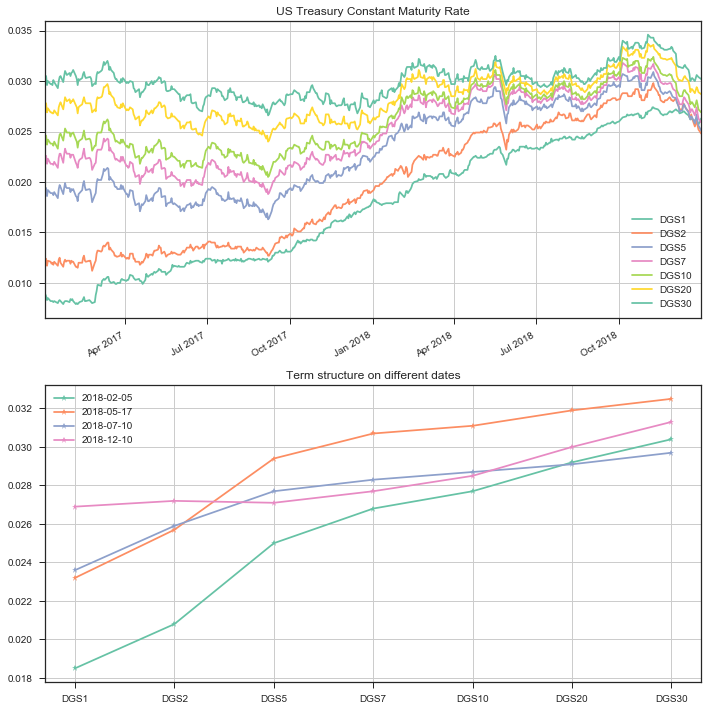

In [7]:
# curve dynamic
fig,(ax,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(10,5*2))
df.plot(grid=True,title='US Treasury Constant Maturity Rate',ax=ax)
x = df.loc[[datetime(2018,2,5),datetime(2018,5,17),datetime(2018,7,10),datetime(2018,12,10)],:]
x.index = [t.date() for t in x.index]
ax2.plot(x.T.index,x.T,marker='*')
ax2.legend(x.index)
ax2.grid(True)
ax2.set_title('Term structure on different dates')
fig.tight_layout()

In [23]:
# contruct pca object
from pca import PCABase
pcab = PCABase(df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
DGS1,0.553153,-0.521945,-0.406891,-0.503280,0.014236,0.049874,0.007363
DGS2,0.548462,-0.229310,0.058753,0.784664,-0.142051,-0.033247,-0.078571
DGS5,0.401411,0.187341,0.458251,-0.105166,0.664757,-0.058601,0.370652
DGS7,0.330703,0.322376,0.348364,-0.263626,-0.146838,0.041370,-0.756690
DGS10,0.279229,0.373706,0.101193,-0.142498,-0.626985,0.304434,0.515790
DGS20,0.180465,0.429733,-0.390784,-0.010568,-0.062438,-0.789335,0.054686
DGS30,0.110360,0.460045,-0.580245,0.173307,0.345178,0.524912,-0.121570


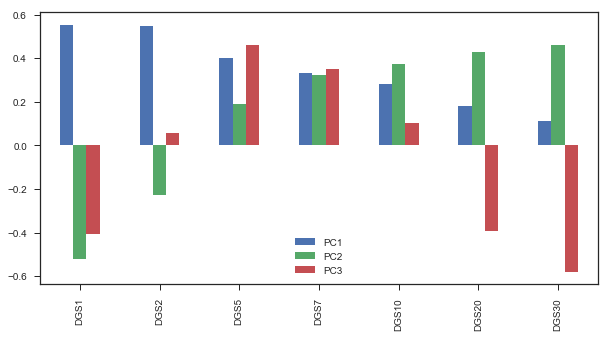

In [33]:
# loading matrix (direction may change but doesn't matter)
V = pd.DataFrame(pcab.pca().components_,index=pcab.pc_names(pcab.n_features),columns=pcab.X.columns)
V.T.iloc[:,0:3].plot(figsize=(10,5),kind='bar')
pcab.cps()

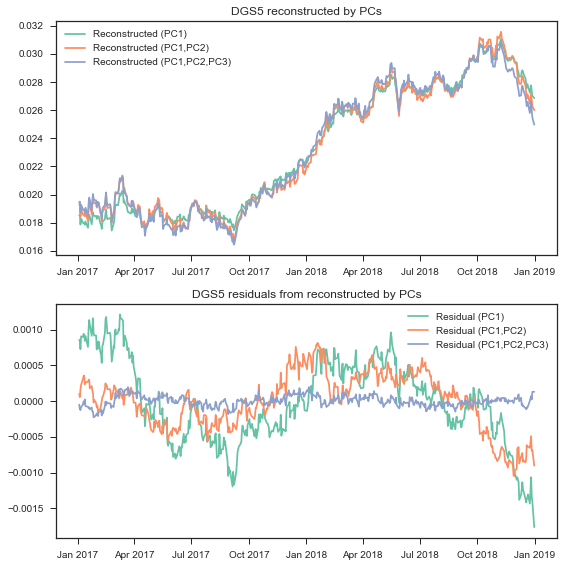

In [17]:
# resconstruction and residuals
r = 'DGS5'
fig,(ax,ax2)=plt.subplots(figsize=(8,4*2),ncols=1,nrows=2)
ax.plot(pcab.x_projected(1)[r])
ax.plot(pcab.x_projected(2)[r])
ax.plot(pcab.x_projected(3)[r])
ax.legend(['Reconstructed (PC1)','Reconstructed (PC1,PC2)','Reconstructed (PC1,PC2,PC3)'])
ax.set_title('{} reconstructed by PCs'.format(r))

ax2.plot(pcab.residuals(1)[r])
ax2.plot(pcab.residuals(2)[r])
ax2.plot(pcab.residuals(3)[r])
ax2.legend(['Residual (PC1)','Residual (PC1,PC2)','Residual (PC1,PC2,PC3)'])
ax2.set_title('{} residuals from reconstructed by PCs'.format(r))
fig.tight_layout()

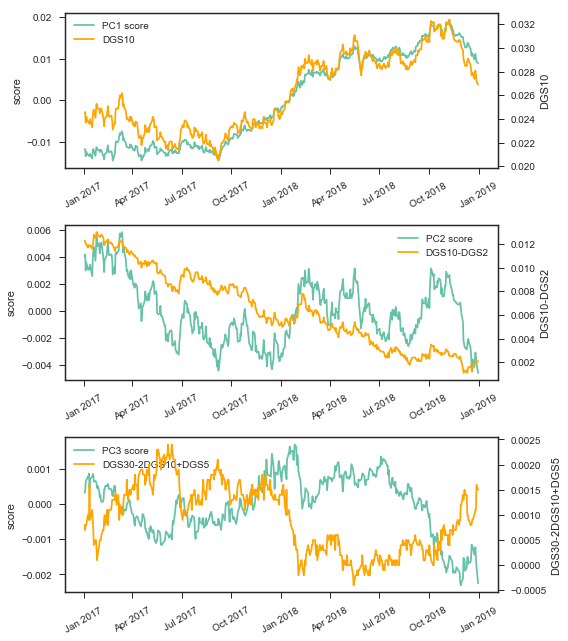

In [19]:
# PC Scores
fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(8,3*3))
l1=ax1.plot(pcab.scores()['PC1'])
ax12 = ax1.twinx()
l2=ax12.plot(pcab.X['DGS10'],color='orange')
ax1.tick_params('x',rotation=30)
ax1.legend(l1+l2,['PC1 score','DGS10'])
ax1.set_ylabel('score')
ax12.set_ylabel('DGS10')
# 
l1=ax2.plot(pcab.scores()['PC2'])
ax22 = ax2.twinx()
l2=ax22.plot(pcab.X['DGS10']-pcab.X['DGS2'],color='orange')
ax2.tick_params('x',rotation=30)
ax2.legend(l1+l2,['PC2 score','DGS10-DGS2'],loc='best')
ax2.set_ylabel('score')
ax22.set_ylabel('DGS10-DGS2')

# 
l1=ax3.plot(pcab.scores()['PC3'])
ax32 = ax3.twinx()
l2=ax32.plot(pcab.X['DGS30']-2*pcab.X['DGS10']+pcab.X['DGS5'],color='orange')
ax3.tick_params('x',rotation=30)
ax3.legend(l1+l2,['PC3 score','DGS30-2DGS10+DGS5'],loc='best')
ax3.set_ylabel('score')
ax32.set_ylabel('DGS30-2DGS10+DGS5')
fig.tight_layout()

Text(0.5, 1.0, 'Evolution of PCA Factors 1,2,3')

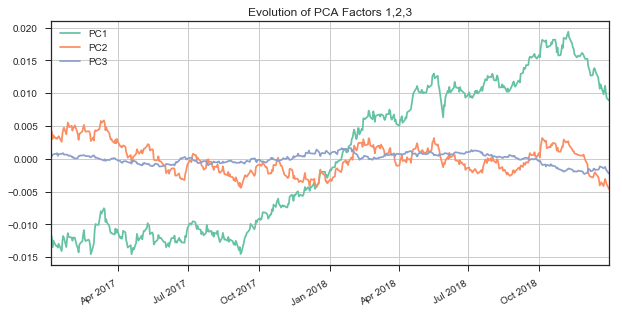

In [20]:
# PC
fig,ax=plt.subplots(figsize=(10,5))
l1=pcab.scores().iloc[:,0:3].plot(ax=ax)
ax.grid(True)
ax.set_title('Evolution of PCA Factors 1,2,3')



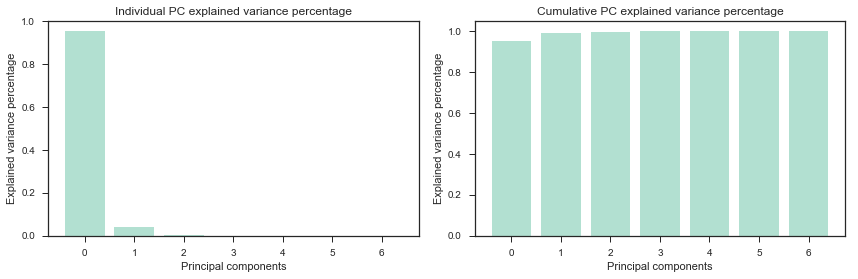

In [22]:
# PCA-explained variance ratio

fig,(ax,ax2) = plt.subplots(figsize=(6*2, 4),ncols=2,nrows=1)
ax.bar(range(pcab.n_features), pcab.cumsum_expvar_ratio()[0], alpha=0.5, align='center')
ax2.bar(range(pcab.n_features), pcab.cumsum_expvar_ratio()[1], alpha=0.5, align='center')
ax.set_ylabel('Explained variance percentage')
ax.set_xlabel('Principal components')
ax.set_title('Individual PC explained variance percentage')
ax.legend(loc='best')
ax2.set_ylabel('Explained variance percentage')
ax2.set_xlabel('Principal components')
ax2.set_title('Cumulative PC explained variance percentage')
ax2.legend(loc='best')
fig.tight_layout()

## PCA and Clustering

In [52]:
from sklearn.cluster import KMeans
def model_kmeans(data,n_clusters=3,init_method = 'k-means++',n_init=10):
  model = KMeans(n_clusters=n_clusters,
                  init=init_method,
                  n_init=n_init)
  model.fit(data)
  cluster_labels = model.predict(data)
  cluster_centers = model.cluster_centers_
  fit_res = {'cluster_method':'kmeans',
              'model':model,
              'cluster_labels':cluster_labels,
              'cluster_centers':cluster_centers,
              'data':data}
  return fit_res

s2 = pcab.scores()[['PC1','PC2']]
kmeans = model_kmeans(s2,n_clusters=2)  
X = s2.reset_index()
X = X.rename(columns={'index':'date'})

feature_pair = ['PC1','PC2']
fig,(ax,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
cluster_labels = kmeans['cluster_labels']
X['cluster_label'] = cluster_labels
cluster_centers = kmeans['cluster_centers']
mode_fitted = kmeans['model']
label_order = sorted(list(set(cluster_labels)))
colors = ['lightgreen','grey','lightblue','yellow']
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, [1,2,5,10])]
color_map_clusters = dict(zip(label_order, colors))
for (c_label,color) in color_map_clusters.items():
  x = X[X['cluster_label']==c_label][feature_pair[0]]
  y = X[X['cluster_label']==c_label][feature_pair[1]]
  ax.scatter(x,y,c=color,alpha=0.8)
ax.legend()
ax.scatter(cluster_centers[:,0],cluster_centers[:,1],c='red',marker='*')
# add cluster center annotion
for xy in tuple(np.round(cluster_centers,2)):
  ax.annotate("({},{})".format(xy[0],xy[1]),xy=(xy[0],xy[1]))
ax.set_xlabel(feature_pair[0])
ax.set_ylabel(feature_pair[1])
ax.legend(['cluster_{}'.format(c) for c in set(cluster_labels)]+['cluster_center'])
ax.set_title('PC1, PC2 scores in clusters')
ax.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax.axvline(x=0,ls='--',color='grey',linewidth=0.6)
# 
X['date'] = pd.to_datetime(X['date'])
periods = pd.date_range(X['date'].iloc[0]-pd.Timedelta(days=3),X['date'].iloc[-1],freq='6M')
X['date_bucket'] = pd.cut(X['date'],bins=periods)
color_map_periods = dict(zip(X['date_bucket'].unique(), colors))
for (p_label,color) in color_map_periods.items():
  x = X[X['date_bucket']==p_label][feature_pair[0]]
  y = X[X['date_bucket']==p_label][feature_pair[1]]
  ax2.scatter(x,y,c=color,alpha=0.8)
ax2.legend()

ax2.set_xlabel(feature_pair[0])
ax2.set_ylabel(feature_pair[1])
ax2.set_title('PC1, PC2 scores by period')
ax2.legend(['period:{}'.format(c) for c in X['date_bucket'].unique()])
ax2.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax2.axvline(x=0,ls='--',color='grey',linewidth=0.6)
fig.tight_layout()

from google.colab import files
plt.savefig('fig7.8.tiff',dpi=350)
files.download('fig7.8.tiff')
save_figure(fig,'pca_cluster_scores.png')
